### 几个发现

- bitmex似乎只能查到最近几天的交易和委托历史。在10月27日下午18点登录网页查看，只能查到10月22日以来的交易记录和委托记录
- textnet测试发现，已撤单的订单在大约10分钟之后会消失，网页端和REST-API(/execution)都查不到了。
- 实盘成交价格可能会超出REST-API查询的历史k线范围。已用实盘交易记录验证（自营账户10月24日4笔买单）

In [1]:
import datetime

report_days = 10   # 最近5天的报告
report_from = datetime.datetime.now() - datetime.timedelta(days=report_days) 

In [2]:
startTime = datetime.datetime.strftime(report_from, '%Y-%m-%d') # '2018-10-20'
endTime = None
symbol = 'XBTUSD'
bar_type = '1h'

account_settings_file = '../bitmex/BITMEX_connect.json'
which = 'tinghao_real_trading'  #'account_test'

In [3]:
import sys
sys.path.append("../")

from bitmex.bitmexREST import bitmexREST
from bitmex.bitmexAccountSettings import bitmexAccountSettings

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",101)

In [4]:
acc = bitmexAccountSettings()
acc.from_config_file(account_settings_file, which)

In [5]:
rest = bitmexREST(apiKey=acc.apiKey, apiSecret=acc.apiSecret, isTestNet=acc.isTestNet)

execution_result = rest.query_history_execution(symbol, startTime, endTime)

df_exec = pd.DataFrame(execution_result)
df_exec['DATETIME'] = pd.to_datetime(df_exec['transactTime'])
#df_exec.head()

In [6]:
all(df_exec.transactTime <= df_exec.timestamp)  # True

True

In [7]:
#df_exec.columns

In [8]:
rest_no_auth = bitmexREST(None, None, True)
market_result = rest_no_auth.query_history_bars(symbol, startTime, endTime, bar_type)

df_market = pd.DataFrame(market_result)
df_market['DATETIME'] = pd.to_datetime(df_market['timestamp'])
#df_market.head()

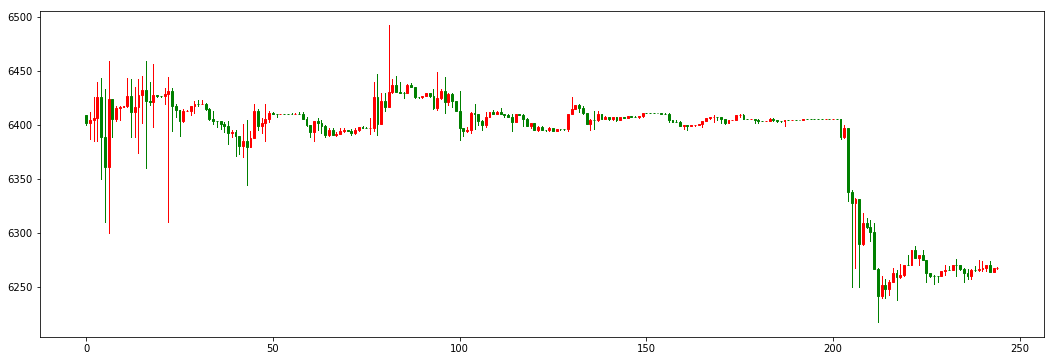

In [19]:
from qsPlot import ohlc_plot


fig, ax = plt.subplots(figsize=(18,6))
ohlc_plot(ax, df_market, width_=0.5)

In [23]:
df_Exec_Trade_Buy = df_exec.query('execType == "Trade" & side=="Buy"')
df_Exec_Trade_Sell = df_exec.query('execType == "Trade" & side=="Sell"')

df_Exec_New = df_exec.query('execType == "New"')
df_Exec_Canceled = df_exec.query('execType == "Canceled"')

print('Buy: %d'% len(df_Exec_Trade_Buy))
print('Sell: %d'% len(df_Exec_Trade_Sell))
print('New: %d' % len(df_Exec_New))
print('Canceled: %d' % len(df_Exec_Canceled))

Buy: 5
Sell: 7
New: 0
Canceled: 0


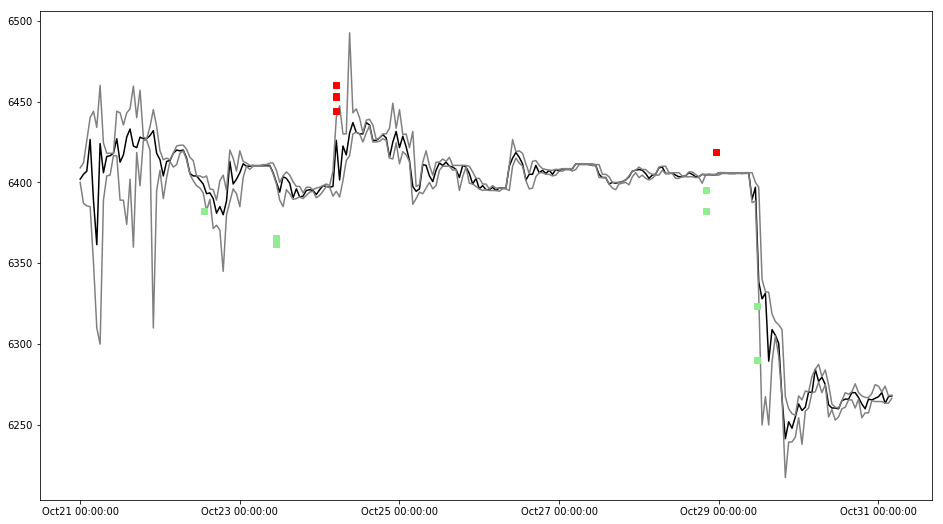

In [45]:
fig,ax = plt.subplots(figsize=(16,9))

ax.plot(df_market.DATETIME, df_market.close, color='k')
ax.plot(df_market.DATETIME, df_market.high, color='grey')
ax.plot(df_market.DATETIME, df_market.low, color='grey')

ax.plot(df_Exec_Trade_Buy.DATETIME, df_Exec_Trade_Buy['lastPx'], 's', color='red')
ax.plot(df_Exec_Trade_Sell.DATETIME, df_Exec_Trade_Sell['lastPx'], 's', color='lightgreen')
ax.plot(df_Exec_New.DATETIME, df_Exec_New['price'], 'o', color='blue')
ax.plot(df_Exec_Canceled.DATETIME, df_Exec_Canceled['price'], '*', color='skyblue')

from matplotlib.dates import DateFormatter

ax.xaxis.set_major_formatter(DateFormatter('%b%d %H:%M:%S'))
#_=plt.xticks(rotation=45)
#_=ax.set_title('%s, %s, %s ~ %s, %s' % (acc.account, symbol, startTime, endTime, bar_type))